# Essais Modélisation Random Forest

In [49]:
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_num = gpd.read_file("donnees_num.geojson")

In [10]:
df_num.head(2)

,ref,min,max,piece,distance_centre_paris,superficie_quartier,score_metro,meuble_bin,q_1,q_2,...,q_76,q_77,q_78,q_79,q_80,epoque_1,epoque_2,epoque_3,epoque_0,geometry
0,25.2,17.64,30.24,3,1.299442,0.869001,0.603253,1,1,0,...,0,0,0,0,0,0,1,0,0,"POLYGON ((2.34459 48.85405, 2.34459 48.85405, ..."
1,22.3,15.61,26.76,3,1.299442,0.869001,0.603253,0,1,0,...,0,0,0,0,0,0,1,0,0,"POLYGON ((2.34459 48.85405, 2.34459 48.85405, ..."


## Random Forest

Pour ce modèle, on considère la base de données `donnees_num.csv`.

On va tenter de prédire le loyer de référence `ref` à partir des variables d'intérêts révélées par le modèle LASSO (avec $\alpha=0.1$), à savoir : `piece`, `distance_centre_paris`, `meuble_bin`, `epoque_1`, `epoque_2`.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

### Implémentation :

On commence par diviser la base de données en un échantillon de test et un jeu d'estimation :

In [104]:
Y = df_num['ref']
X = df_num[['piece', 'distance_centre_paris', 'meuble_bin', 'epoque_1', 'epoque_2']]

xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.2, random_state = 0)

Ensuite, on utilise `RandomForestRegressor` sur le jeu d'estimation. Pour commencer, on choisit un hyperparamètre $n=10$ de 10 arbres dans notre Random Forest. 

In [105]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(xTrain, yTrain)

#Prédiction du jeu de données test : 
yPred = regressor.predict(xTest)

On peut créer une base de données `resultat` qui recence les loyers effectifs et réels de la base de données test :

In [106]:
resultats = pd.DataFrame({'Loyers effectifs': list(yTest), 'Loyers prédis': list(yPred)})

### Visualisation des résultats : 

On peut commencer par visualiser simplement l'écart entre les loyers prédits et les loyers effectifs sur les 20 premières observations du jeu de données test :

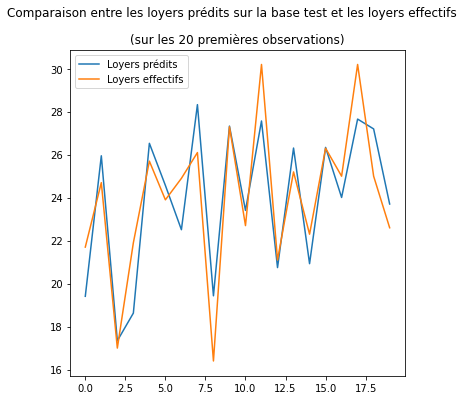

In [107]:
plt.figure(figsize=(6,6))

plt.plot(list(yPred)[:20],label='Loyers prédits')
plt.plot(list(yTest)[:20],label='Loyers effectifs')

plt.suptitle('Comparaison entre les loyers prédits sur la base test et les loyers effectifs')
plt.title('(sur les 20 premières observations)')
plt.legend()

On peut faire une vue d'ensemble en traçant les loyers prédis en fonction des loyers effectifs sur le jeu de données test :

Text(0.5, 1.0, 'Loyers prédis en fonction des loyers effectifs pour le jeu de données test')

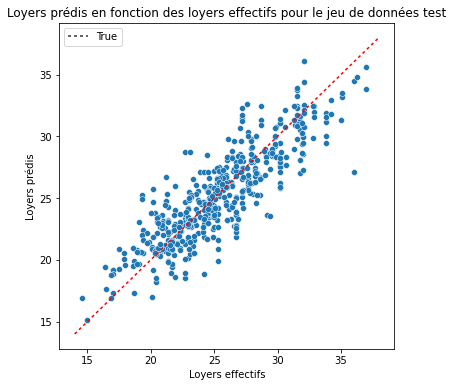

In [108]:
plt.figure(figsize=(6,6))

sns.scatterplot(data=resultats, x="Loyers effectifs",y="Loyers prédis")

identite = [i for i in range(14,39)]
sns.lineplot(x=identite,y=identite,style=True, dashes=[(2,2)],color="red")

plt.title("Loyers prédis en fonction des loyers effectifs pour le jeu de données test")

On peut également calculer des indicateurs de performance  :
- MAE (Mean Absolute Error) : $MAE = \mathbb{E}\big[|\widehat{ref}-ref|\big]$
- MSE (Mean Squarred Error) : $MSE = \mathbb{E}\big[(\widehat{ref}-ref)^2\big]$
- RMSE (Root Mean Squarred Error) : $RMSE = \sqrt{MSE}$
- MAPE (Mean Absolute Percentage Error) : $MAPE = \mathbb{E}\bigg[\frac{|\widehat{ref}-ref|}{ref}\bigg]$

In [109]:
resultats['Ecarts_abs'] = abs(resultats['Loyers prédis']-resultats['Loyers effectifs'])
resultats['Ecarts^2'] = resultats['Ecarts_abs']**2
resultats['Percentage'] = resultats['Ecarts_abs']/resultats['Loyers effectifs']

In [110]:
MAE = resultats['Ecarts_abs'].mean()
MSE = resultats['Ecarts^2'].mean()
RMSE = MSE**0.5
MAPE = resultats['Percentage'].mean()

In [111]:
print(pd.DataFrame({'MAE' : [MAE], 'MSE' : [MSE], 'RMSE' : [RMSE], 'MAPE' : [MAPE]}))

       MAE       MSE     RMSE      MAPE
0  1.56951  4.211033  2.05208  0.063057


### Création d'une fonction qui fait tout !

In [122]:
def RandomForest (data,ref,variables,n_arbres,test_size=0.2,affichage=True) :
    """Fonction qui réalise un RandomForest 
    
    Entrées :
    - data : base de données numérique, standardisées
    - ref : variable à prédire
    - variables : liste des variables à utiliser pour prédire la variable ref
    - n_arbres : hyperparamètre du RandomForest, nombre d'arbres de décision créés
    - test_size : taille de l'échantillon de données test, par défaut 0.2.
    - plot : booléen indiquant si les graphes doivent être tracés
    
    Sorties :
    - Indicateurs de performances : MSE, RMSE et MAPE
    - si affichage == True : 
        * Affichage des indicateurs de performances
        * Scatter plot représentant les valeurs effectives en fonction des valeurs prédites pour le jeu de données test
        * Densité des écarts (en valeur absolue) entre valeurs effectives et valeurs prédites pour le jeu de données test
    """
    
    #Division du jeu de données en un jeu test et un jeu d'estimation :
    Y = data[ref]
    X = data[variables]
    xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = test_size, random_state = 0)
    
    #Entrainement du modèle : 
    regressor = RandomForestRegressor(n_estimators = n_arbres, random_state = 0)
    regressor.fit(xTrain, yTrain)
    
    yPred = regressor.predict(xTest)
    resultats = pd.DataFrame({'Données effectives': list(yTest), 'Prédictions': list(yPred)})  
    
    #Indicateurs de performance :
    resultats['Ecarts_abs'] = abs(resultats['Prédictions']-resultats['Données effectives'])
    resultats['Ecarts^2'] = resultats['Ecarts_abs']**2
    resultats['Percentage'] = resultats['Ecarts_abs']/resultats['Données effectives']
    
    MAe = resultats['Ecarts_abs'].mean()
    MSE = resultats['Ecarts^2'].mean()
    RMSE = MSE**0.5
    MAPE = resultats['Percentage'].mean()
    
    #Affichage des indicateurs et des graphiques si affichage == True : 
    if affichage : 
        print(pd.DataFrame({'MAE' : [MAE], 'MSE' : [MSE], 'RMSE' : [RMSE], 'MAPE' : [MAPE]}))
        
        fig,ax = plt.subplots(1, 2, figsize=(12, 6)) 
        
        #Scatter plot :
        sns.scatterplot(data=resultats, x='Données effectives',y='Prédictions',ax = ax[0])
        identite = [i for i in range(int(resultats['Prédictions'].min()),int(resultats['Prédictions'].max()))]
        sns.lineplot(x=identite,y=identite,style=True, dashes=[(2,2)],color="red",ax = ax[0])
        ax[0].set_title("Prédictions en fonction des valeurs \n effectives pour le jeu de données test")
        
        #Densité :
        sns.kdeplot(resultats['Ecarts_abs'],ax = ax[1], fill=True, alpha=.3)
        ax[1].set_title("Répartition des écarts entre valeurs prédites \n et effectives pour le jeu de données test \n (en valeur absolue)")   
    
    return (MAE, MSE, RMSE, MAPE)
    

### Tests de différents modèles :

- On commence par augmenter le nombre d'arbres de la foret aléatoire :

       MAE       MSE     RMSE      MAPE
0  1.56951  4.211033  2.05208  0.063057


(1.5695102306547617,
 4.211032824404763,
 2.0520801213414557,
 0.06305748357915499)

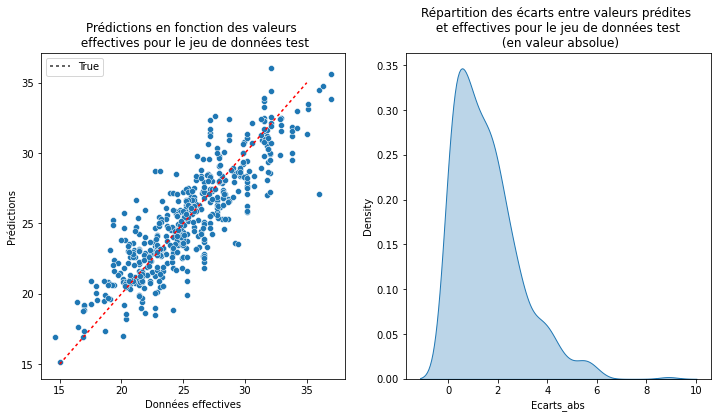

In [123]:
RandomForest(df_num,'ref',['piece', 'distance_centre_paris', 'meuble_bin', 'epoque_1', 'epoque_2'],10,test_size=0.2)

       MAE       MSE     RMSE      MAPE
0  1.56951  4.092973  2.02311  0.061775


(1.5695102306547617,
 4.092972505981577,
 2.0231096129428026,
 0.06177529947489689)

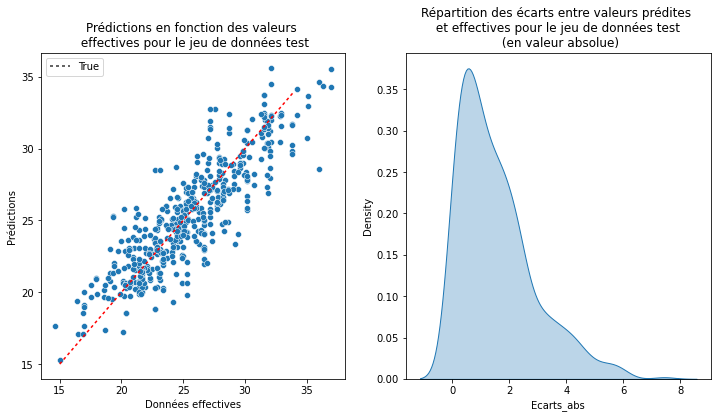

In [124]:
RandomForest (df_num,'ref',['piece', 'distance_centre_paris', 'meuble_bin', 'epoque_1', 'epoque_2'],50,test_size=0.2)

       MAE       MSE      RMSE      MAPE
0  1.56951  3.999385  1.999846  0.061175


(1.5695102306547617,
 3.9993850728231397,
 1.9998462622969646,
 0.06117508309443405)

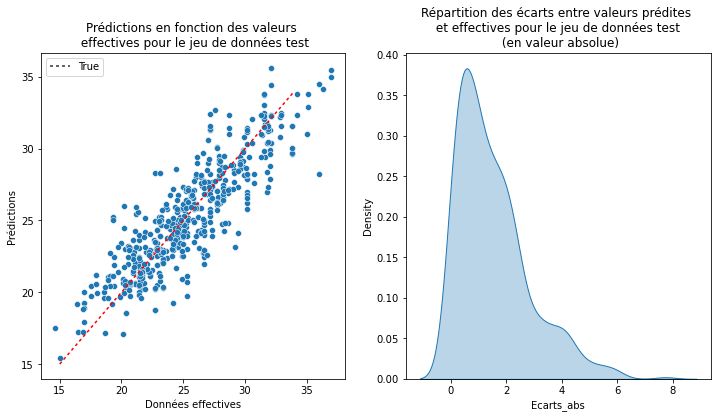

In [125]:
RandomForest (df_num,'ref',['piece', 'distance_centre_paris', 'meuble_bin', 'epoque_1', 'epoque_2'],100,test_size=0.2)

- On peut aussi essayer en prenant en compte plus de variables explicatives, plutot que celles choisies par le Lasso, par exemple en ajoutant `superficie_quartier` :

       MAE       MSE      RMSE     MAPE
0  1.56951  3.060702  1.749486  0.05527


(1.5695102306547617, 3.060702090550292, 1.749486236170577, 0.05526957392753023)

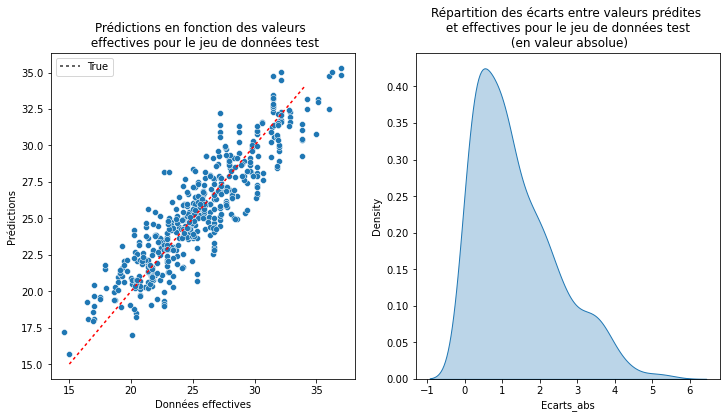

In [126]:
RandomForest (df_num,'ref',['piece', 'distance_centre_paris', 'meuble_bin', 'epoque_1', 'epoque_2','superficie_quartier'],50,test_size=0.2)

## + Faire une validation croisée de type k-fold pour l'hyperparamètre `n_arbre`
## + Faire attention aux phénomènes de sur-apprentissage... 